In [1]:
#Python >= 3.5 version is required 
import sys
assert sys.version_info>=(3,5)

##We will be using Sklearn for our project and hence we would need a version >=0.20
import sklearn
sklearn.__version__>="0.20"

True

In [2]:
##We mute the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

### 1: Importing the Relevant Libraries

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=20)
mpl.rc('ytick',labelsize=20)

from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score

from sklearn.model_selection import KFold, cross_val_predict,RepeatedKFold,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline

### 2. Take a Quick Look at the Data Structure

In [40]:
train = pd.read_csv(r'C:\Users\hp\Python\Jupyter files\Jobs Test_Interviews Answers\Analytics Vidhya Jobathon\Jobathon AV Feb-22 (ML Assignment)\trainData.csv')
test = pd.read_csv(r'C:\Users\hp\Python\Jupyter files\Jobs Test_Interviews Answers\Analytics Vidhya Jobathon\Jobathon AV Feb-22 (ML Assignment)\testData.csv')
                   
print(f'The number of rows in the training set is {train.shape[0]} and the number of columns is {train.shape[1]}')
print(f'The number of rows in the test set which will be our hold out set is {test.shape[0]} and the number of columns is {test.shape[1]}')

The number of rows in the training set is 89197 and the number of columns is 10
The number of rows in the test set which will be our hold out set is 11121 and the number of columns is 9


In [9]:
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35
3,4,12597,23,112,19,Male,Student,220,613,3.77
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13


__We check the porportion of null values in each of the columns followed by the data types of the different columns__

In [10]:
print(train.isnull().sum())
print('-'*80)
print(test.isnull().sum())

row_id              0
user_id             0
category_id         0
video_id            0
age                 0
gender              0
profession          0
followers           0
views               0
engagement_score    0
dtype: int64
--------------------------------------------------------------------------------
row_id         0
user_id        0
category_id    0
video_id       0
age            0
gender         0
profession     0
followers      0
views          0
dtype: int64


In [25]:
(train.groupby('video_id').mean()['views']%1>0).any()== True
##Hence it means thta there are video Ids which have 

True

In [27]:
cat_cols=train.dtypes[train.dtypes==np.object]
num_cols=train.select_dtypes(exclude='object')

In [28]:
cat_cols.index

Index(['gender', 'profession'], dtype='object')

In [29]:
num_cols.columns

Index(['row_id', 'user_id', 'category_id', 'video_id', 'age', 'followers',
       'views', 'engagement_score'],
      dtype='object')

__a) Hence we observe that we do not have missing values in our training as well as the hold out set.__

__b) Secondly, we have segregated the categorical columns and the numeric columns for further analysis. We note that there are only two string categoricals in our training set namely `"gender" and "profession".`__

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89197 entries, 0 to 89196
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_id            89197 non-null  int64  
 1   user_id           89197 non-null  int64  
 2   category_id       89197 non-null  int64  
 3   video_id          89197 non-null  int64  
 4   age               89197 non-null  int64  
 5   gender            89197 non-null  object 
 6   profession        89197 non-null  object 
 7   followers         89197 non-null  int64  
 8   views             89197 non-null  int64  
 9   engagement_score  89197 non-null  float64
dtypes: float64(1), int64(7), object(2)
memory usage: 6.8+ MB


### 3. Exploratory Data Analysis & Data Cleaning

In [31]:
train.head(3)

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35


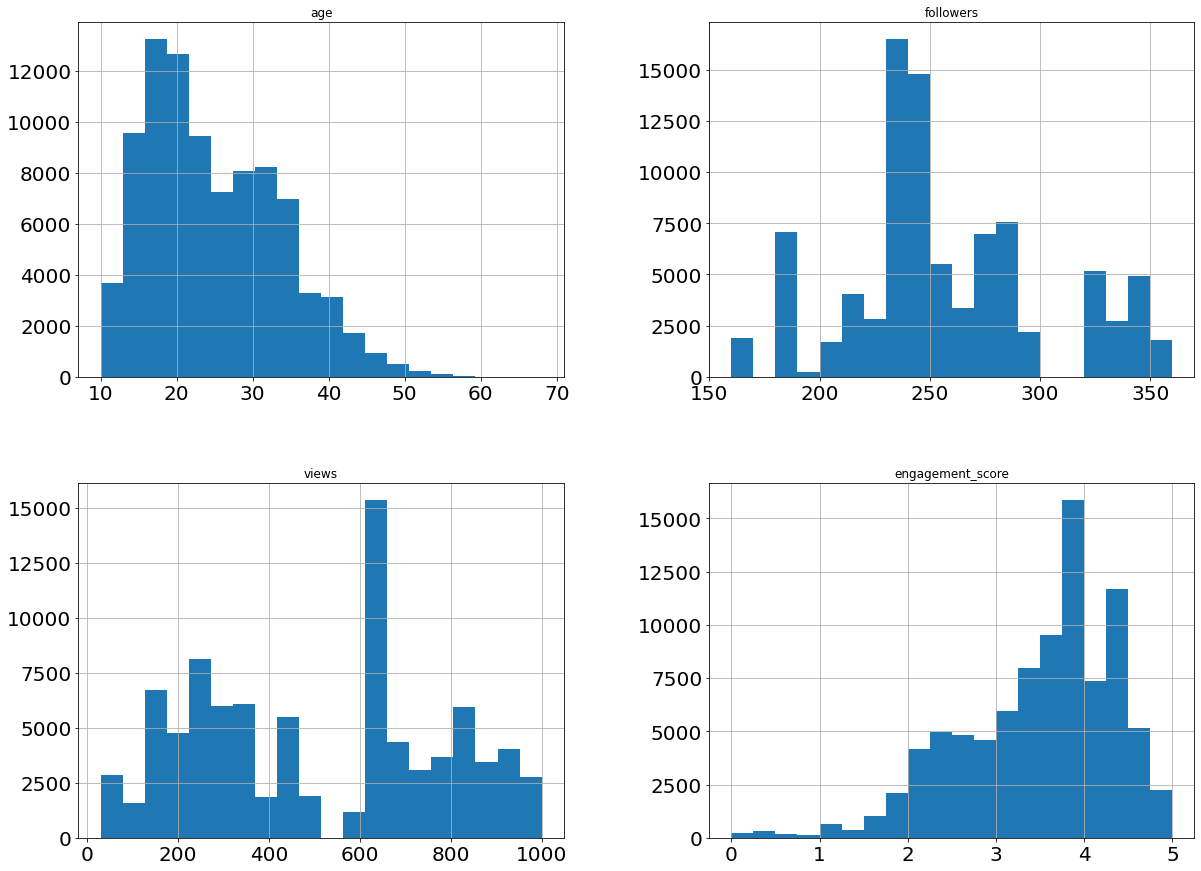

In [32]:
# We plot a histogram of the columns removing the IDs like user_id,video_id etc.
hist_df = train.iloc[:,4:]
hist_df.hist(bins=20,figsize=(20,15))
plt.show()

* Here we observe that the column 'age' is right skewed.
* Column 'Engagement score' is left skewed

__'Engagement score' is our TARGET variable hence we would ensure that the values are normally distributed__

In [33]:
## No we see some statistics related to our numeric data
stats=hist_df.describe()
stats

,age,followers,views,engagement_score
count,89197.000000,89197.000000,89197.000000,89197.000000
mean,24.848616,252.460172,502.980268,3.487797
std,8.955535,46.094468,268.569482,0.863498
min,10.000000,160.000000,30.000000,0.000000
25%,18.000000,230.000000,229.000000,2.900000
50%,23.000000,240.000000,467.000000,3.710000
75%,32.000000,280.000000,714.000000,4.150000
max,68.000000,360.000000,1000.000000,5.000000


__The inferences made from the statistics table are the following: -__

* Only 25% of the total users recorded are aged above 32 which explains the skewness in the 'age' column
* Only less than 25% of the engaement scores are less than 2.90 which again explains the left skewness.

___Now we make some visuals for the string categoricals___

* Fristly, we observe that the porportion of males is almost 18% more than the proprotion of females.
* Secondly, in our Professions column, close to 51% of the users are students while the 'working professionals' account for only 20% of the total users.

In [34]:
def countPlot(train,s):
    plt.figure(figsize=(10,5))
    sns.countplot(s,data=train)
    plt.show()
    print(train[s].value_counts(normalize=True)*100)

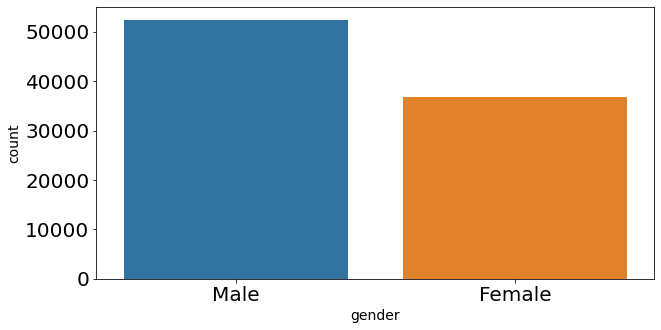

Male      58.743007
Female    41.256993
Name: gender, dtype: float64


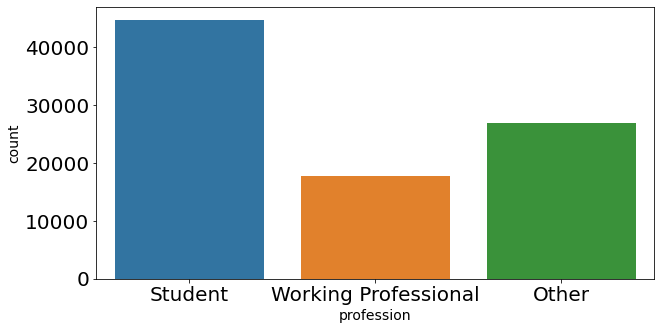

Student                 50.044284
Other                   30.090698
Working Professional    19.865018
Name: profession, dtype: float64


In [35]:
countPlot(train,'gender')
countPlot(train,'profession')

### Analysis on the Age column

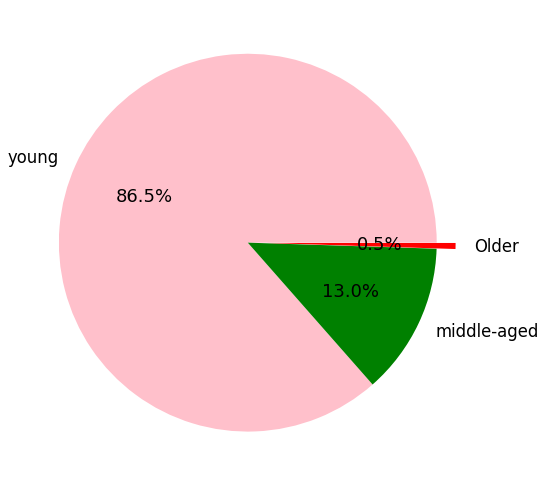

In [36]:
##We formulate some groups and make our analysis on the age
young = train[(train['age']>=10) & (train['age']<=35)]
middle_aged = train[(train['age']>35) & (train['age']<=50)]
older = train[train.age>50]

sns.set_context('talk',font_scale = 1)
plt.figure(figsize=(8,10))
colors = ['pink','green','red']
explode = [0,0,0.1]
plt.pie([len(young),len(middle_aged),len(older)],labels=['young','middle-aged','Older'],explode=explode,colors=colors, autopct='%1.1f%%')
plt.tight_layout()
plt.show()

__Hence we observe, from all the users, 86.5% are users falling under the range of age 10-35 years. The proportion of users above the 50 years is merely 0.5%__

#### Some light on Followers and Views on the videos

In [37]:
fol = train.groupby(['video_id']).agg({'views':'sum','followers':'sum'}).reset_index()
fol.sort_values(by='views',ascending=False)

,video_id,views,followers
0,1,840069,371690
111,112,819581,294140
52,53,817742,293480
49,50,623574,219520
1,2,615780,223920
...,...,...,...
19,20,15884,75810
80,81,15288,76440
174,175,11656,12220
2,3,5010,36740


__1) Hence we observe that Video_ID - 1 has the most number of views and followers__

__2) Video_id 175 has the least number of followers while videos falling under the category of video_id 38 has the least number of views.__


In [38]:
famous_cat = train.groupby(['category_id']).agg({'views':'sum','followers':'mean'}).reset_index()
print(famous_cat.sort_values(by='followers',ascending=False).head(1))
print('-'*80)
print(famous_cat.sort_values(by='followers',ascending=False).tail(1))
print('-'*80)
print(famous_cat.sort_values(by='views',ascending=False).head(1))
print('-'*80)
print(famous_cat.sort_values(by='views',ascending=False).tail(1))

   category_id    views  followers
0            1  1791900        360
--------------------------------------------------------------------------------
   category_id   views  followers
6            7  880295        160
--------------------------------------------------------------------------------
   category_id    views  followers
7            8  3964564        280
--------------------------------------------------------------------------------
   category_id  views  followers
1            2   5010        220


### Inferences

>Hence we see that the videos falling under the category 1 have most number of followers while videos falling under the category of id 7 has the least number of followers.

>Similarly, videos under category 8 have the most number of views while videos under category 2 have the least number of views.

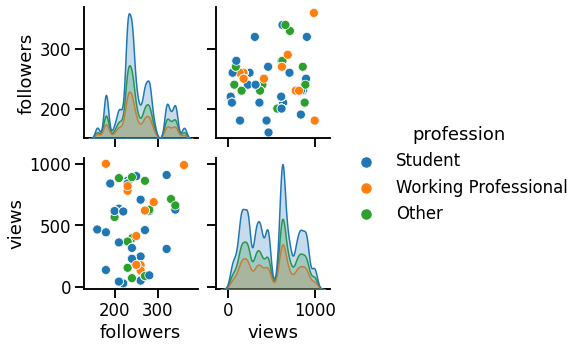

In [39]:
z= train[['followers','views','profession']]
sns.set_context('talk')
sns.pairplot(z,hue='profession')

__Hence these plots do not tell much about the professional category and number of views and followers as the data points are too scattered to infer, but one thing is sure that Students are clearly dominating__

#### We now check for correlations

In [20]:
## We remove certain unwanted columns like the unique identifiers which do not add any meaning to the analyses
num_cols_corr = num_cols.iloc[:,2:]
num_cols_corr=num_cols_corr.drop(['video_id'],axis=1)
num_cols_corr.head()

,category_id,age,followers,views,engagement_score
0,37,24,180,1000,4.33
1,32,14,330,714,1.79
2,12,19,180,138,4.35
3,23,19,220,613,3.77
4,23,27,220,613,3.13


In [21]:
corr_mat=num_cols_corr.corr()
corr_mat

,category_id,age,followers,views,engagement_score
category_id,1.000000,-0.003152,0.056432,0.079321,-0.094288
age,-0.003152,1.000000,0.004623,0.011042,-0.232626
followers,0.056432,0.004623,1.000000,0.360808,0.000855
views,0.079321,0.011042,0.360808,1.000000,-0.084679
engagement_score,-0.094288,-0.232626,0.000855,-0.084679,1.000000


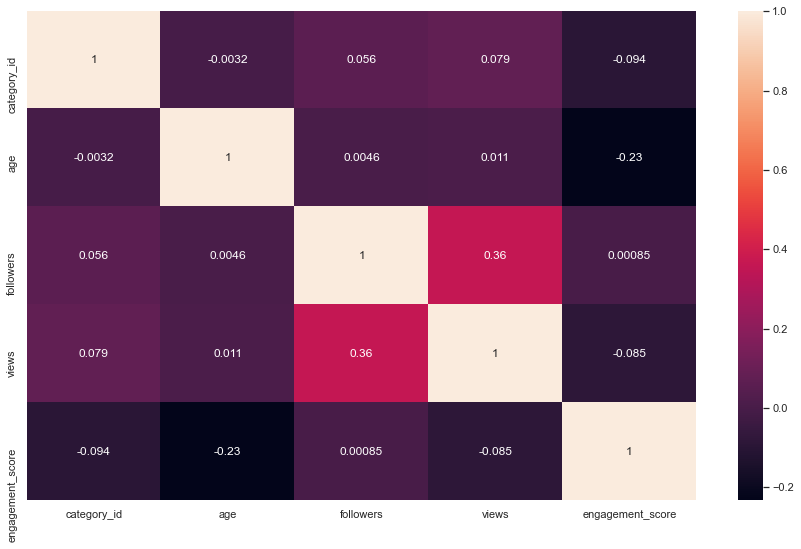

In [23]:
sns.heatmap(corr_mat,annot=True)
sns.set(rc = {'figure.figsize':(15,9)})
sns.set()

## Inferences

>__a) We infer that there is not much correlation between the features hence Multicollinearity would not be a hurdle in case of modelling__

>__b) The highest correlation in absolute terms is between age and the engagement_score. The correlation is around negative 0.2 which means that as people grow older there is a slight downfall in the engagement score which is well established in the skewness of our age column in our data__

## 4. Feature Engineering

#### Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy.

`Since we will be making modifications in our training set itself hence we create a copy of the data so that we could re-use it further if needed. Otherwise, the data being used for feature engineering will be use to build our model`

In [24]:
train_2 = train.copy()

In [25]:
test_2 = test.copy()

##### Feature creation

__Now, we could get a great deal about the categories of videos after observing their number of followers and number of views. Supposedly, if we divide our number of followers with our number of views, we could assess the quality of the categories of the videos.__

__For example, if a category has 100 followers and 200 total views then views/followers gives us 2 which means that each follower has, on an average, seen the videos under that category twice.__

__On the other hand, if the followers remain the same for another category of videos but the number of views increases to 400 then it might mean that the videos in the latter category are liked more by the users__

In [26]:
train['viewsPerFollower'] = train['views']/train['followers']
test['viewsPerFollower'] = test['views']/test['followers']

In [27]:
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,viewsPerFollower
0,1,19990,37,128,24,Male,Student,180,1000,4.33,5.555556
1,2,5304,32,132,14,Female,Student,330,714,1.79,2.163636
2,3,1840,12,24,19,Male,Student,180,138,4.35,0.766667
3,4,12597,23,112,19,Male,Student,220,613,3.77,2.786364
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13,2.786364


In [28]:
cat_cols

gender        object
profession    object
dtype: object

### Feature Transformations - One-hot Encoding 

#### Machines understand numbers, not text. We need to convert each text category to numbers in order for the machine to process them using mathematical equations


##### a) We shall apply one-hot encoding as our categorical features are not oridnal(they do not have any order like low, medium and high). We go forward with Label encoder when our features are ordinal.
##### b) Now for the nominal features we first check the number of unique columns that would be added to the data frame since one hot encoding adds a new feature for each of the unique values. So, if the number of new additions is not very high, then we shall go forward with one hot encoding.

`We bifurcate our data set and drop columns like user_id & video_id as they are columns with unique values and would not contribute much in terms of training our model.`



In [29]:
y=train['engagement_score']
x=train.drop(columns=['user_id','video_id','engagement_score'], axis=1)

In [30]:
# x_data = x.copy()
# x_le=['gender','profession']
# le = LabelEncoder()
# for v in x_le:
#     x_data[v]=le.fit_transform(x_data[v])

In [31]:
x_ohe=['gender','profession']
le = LabelEncoder()
ohe = OneHotEncoder()
x_data = x.copy()
final_test = test.copy()
for c in x_ohe:
    
    #Integer encode the strting categories
    d = le.fit_transform(x_data[c])
    p = le.transform(final_test[c])
    
    #One hot encode
    new_d = ohe.fit_transform(d.reshape(d.shape[0],1)) #A 2D array is required for one hot encoding,also it gives a sparse array.
    new_p = ohe.transform(p.reshape(p.shape[0],1)) 
    
    
    #Remove the original categorical column from the data frame
    x_data = x_data.drop(c,axis=1)
    final_test = final_test.drop(c,axis=1)
    
    #give a new column name
    col_name = ['_'.join([c,str(z)]) for z in range(new_d.shape[1])]
    column_name = ['_'.join([c,str(z)]) for z in range(new_p.shape[1])]
    
    
    #Covert the series into a data frame
    new_df = pd.DataFrame(new_d.toarray(),index = x_data.index,columns=col_name)
    new_dff = pd.DataFrame(new_p.toarray(),index = final_test.index,columns=column_name)
    
    #Concatenate the new data frame created with the original data frame
    x_data = pd.concat([x_data,new_df],axis=1)
    final_test = pd.concat([final_test,new_dff],axis=1)
    
    

In [33]:
# Hence we have the updated data frame with 11 columns and the categorical columns removed.
x_data.head()

,row_id,category_id,age,followers,views,viewsPerFollower,gender_0,gender_1,profession_0,profession_1,profession_2
0,1,37,24,180,1000,5.555556,0.0,1.0,0.0,1.0,0.0
1,2,32,14,330,714,2.163636,1.0,0.0,0.0,1.0,0.0
2,3,12,19,180,138,0.766667,0.0,1.0,0.0,1.0,0.0
3,4,23,19,220,613,2.786364,0.0,1.0,0.0,1.0,0.0
4,5,23,27,220,613,2.786364,0.0,1.0,0.0,0.0,1.0


### Feature Transformation - Applying Log transform

__We had earlier observed that our age column is right skewed and hence we would apply the log transformation in order to combat the skewness and make the column nearly NORMAL__

__Below we see how the log transformation combats the skewness in the data set__

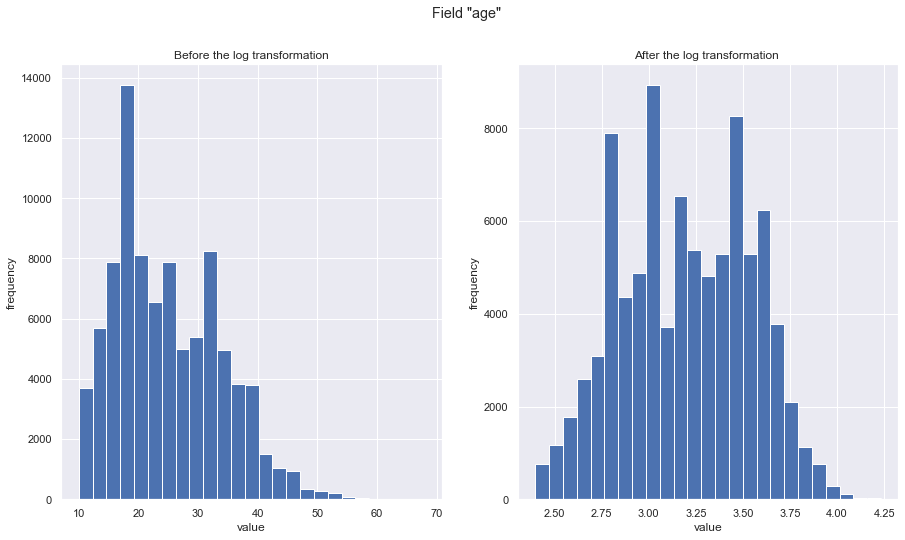

In [34]:
fig,(ax_before,ax_after) = plt.subplots(1,2,figsize=(15,8))
col = 'age'

##Plotting one column or field without log transformation
x_data[col].hist(bins=25,ax=ax_before)

# Apply a log transformation (numpy syntax) to this column now
x_data[col].apply(lambda x:np.log1p(x)).hist(ax=ax_after,bins=25)

#Changing the titles of the graphs
ax_before.set(title = 'Before the log transformation',ylabel='frequency', xlabel='value')
ax_after.set(title = 'After the log transformation ',ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(col))
plt.show()

>1)Hence we see that the log transformation does change the column to a column with values nearly normally distributed.

>2)Kindly note that age cannot be anything but whole numbers, but for the purpose of training the model we have performed the log transformation

In [35]:
x_data['age'] = x_data.age.apply(lambda x:np.log1p(x))

In [36]:
x_data.head(3)

,row_id,category_id,age,followers,views,viewsPerFollower,gender_0,gender_1,profession_0,profession_1,profession_2
0,1,37,3.218876,180,1000,5.555556,0.0,1.0,0.0,1.0,0.0
1,2,32,2.708050,330,714,2.163636,1.0,0.0,0.0,1.0,0.0
2,3,12,2.995732,180,138,0.766667,0.0,1.0,0.0,1.0,0.0


In [37]:
#We set aside 20% of the data as a validation set to check the accuracy of our model.
x_train,x_valid,y_train,y_valid = train_test_split(x_data,y,test_size=0.2,random_state=45)

__Fitting the `LinearRegressor`__

In [38]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_valid)

In [39]:
r2_score(y_valid,y_pred)

0.2656712297844388

In [40]:
r2_score(y_train,lr.predict(x_train))

0.27376100725866226

__Hence we see that the R^2 is low in both the cases which indicates that our Linear regression model is underfitting. Now we try fitting the `**decision tree regressor**` which is a powerful model, capable of finding complex non-linear relationships__

In [39]:
dr = DecisionTreeRegressor(random_state=0)
dr.fit(x_train,y_train)
y_pred1 = dr.predict(x_valid)
r2_score(y_valid,y_pred1)

-0.3616622350996914

In [40]:
r2_score(y_train,dr.predict(x_train))

1.0

__Here we see that the training error is zero while the test error is quite low which means the model has been overfitted badly.
Therefore, we try one more model called the `Random Forest Regressor` which is essentiaklly training `Decision trees` on random subsets of the features, then averaging out the predictions. This is also known as the `Ensemble learning` and hence `Random forest is an ensemble model.`__

In [42]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(x_train,y_train)
forest_pred = forest_reg.predict(x_valid)
r2_score(y_valid,forest_pred)

0.20968622116571

In [43]:
##Checking on the training set
forest_pred_tr = forest_reg.predict(x_train)
r2_score(y_train,forest_pred_tr) #--random forest overfitting

0.8918820172128574

__Hence we notice that random forest is performing worse than Linear regression and it has been overfitting the data__

-----------------------------------------------------------------------------------------------------------------------------
### a) Now we will focus on fine tuning the random forest model by tweaking the hyper parameters using Grid Search that essentially evalutes all the values of the hyperparameter values, using cross validation.

### b) Cross validation is a technique of validating our model so that it becomes generalizable. It involves dividing the training set into subsets and validation sets and then checking the accuracy amongst these sets without touching the test set. We will be using K-Fold Cross Validation wherein the training data set is divided into k subsets.

In [46]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30,40], 'max_features': [2, 4, 6, 8,10]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='r2',
                           return_train_score=True)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8, 10],
                          'n_estimators': [3, 10, 30, 40]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='r2')

In [47]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 40}

In [50]:
cvres = grid_search.cv_results_
for r2, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(r2, params)

0.04004525351571597 {'max_features': 2, 'n_estimators': 3}
0.15038587777283882 {'max_features': 2, 'n_estimators': 10}
0.18408111359492418 {'max_features': 2, 'n_estimators': 30}
0.18720998003755918 {'max_features': 2, 'n_estimators': 40}
0.03861003631192459 {'max_features': 4, 'n_estimators': 3}
0.15322396016643738 {'max_features': 4, 'n_estimators': 10}
0.18564096096797172 {'max_features': 4, 'n_estimators': 30}
0.18857092469970507 {'max_features': 4, 'n_estimators': 40}
0.043403575679342235 {'max_features': 6, 'n_estimators': 3}
0.16227941431983875 {'max_features': 6, 'n_estimators': 10}
0.19613895280275245 {'max_features': 6, 'n_estimators': 30}
0.19916831252381212 {'max_features': 6, 'n_estimators': 40}
0.0479882742394991 {'max_features': 8, 'n_estimators': 3}
0.1714196542525188 {'max_features': 8, 'n_estimators': 10}
0.20679526637177545 {'max_features': 8, 'n_estimators': 30}
0.2105056742240996 {'max_features': 8, 'n_estimators': 40}
0.04477224524419654 {'max_features': 10, 'n_es

__Hence we saw that tuning the parameter did not help. So, we focus on correcting the Underfitting by adding in more polynomial features.__

In [70]:
pf = PolynomialFeatures(degree=3) #We formulate an instance and then fit it
x_train_pf = pd.DataFrame(pf.fit_transform(x_train))
x_test_pf = pd.DataFrame(pf.transform(x_valid))

In [71]:
lr.fit(x_train_pf,y_train)
pred = lr.predict(x_test_pf)

In [72]:
r2_score(y_valid,pred)

0.2881184256622612

__Hence after adding the polynomial features we were able to improve the accuracy but not as much as we would have intended__

### So, now we try our last model which is known as the Light Gradient Boosted Machine, or LightGBM. It extends the gradient boosting algorithm by adding a type of automatic feature selection as well as focusing on boosting examples with larger gradients

In [54]:
import lightgbm as lgb
model = lgb.LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

>We work on our **x_data** without worrying about the splits as we shall be using **cross validation** scores to check the accuracy of LightGBM. Cross validation is effective as it does not shrink our training data which might help the model in the learning.

In [56]:
## We first remove the row_id from the data set as it seems of no use 
# x_data = x_data.drop(columns = ['row_id'],axis=1)
x_data.head() #Removed the same

,category_id,age,followers,views,viewsPerFollower,gender_0,gender_1,profession_0,profession_1,profession_2
0,37,3.218876,180,1000,5.555556,0.0,1.0,0.0,1.0,0.0
1,32,2.708050,330,714,2.163636,1.0,0.0,0.0,1.0,0.0
2,12,2.995732,180,138,0.766667,0.0,1.0,0.0,1.0,0.0
3,23,2.995732,220,613,2.786364,0.0,1.0,0.0,1.0,0.0
4,23,3.332205,220,613,2.786364,0.0,1.0,0.0,0.0,1.0


In [57]:
n_scores = cross_val_score(model,x_data,y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')

In [58]:
n_scores.mean()

0.3520021007340574

### Hence we see that we would be able to increase the score with LightGBM as the average scores come out to be 35.21. Let us see if adding polynomial features would help.

### Further we see that there is a slight improvement with addition of polynomial features.

In [45]:
#Transforming our x_data
pf = PolynomialFeatures(degree=3) #We formulate an instance and then fit it
x_data_pf = pf.fit_transform(x_data)

In [46]:
n_scores_pf = cross_val_score(model,x_data_pf,y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
n_scores_pf.mean()

0.35284437541915903

### Now we make changes in our test set so that we could train our model on the same. Note that while encoding we will just transform as we have already fitted the training set

In [47]:
test.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,viewsPerFollower
0,89198,7986,12,42,14,Male,Student,180,138,0.766667
1,89199,11278,34,115,14,Male,Student,230,840,3.652174
2,89200,17245,8,110,44,Female,Working Professional,280,628,2.242857
3,89201,9851,16,137,18,Male,Student,270,462,1.711111
4,89202,16008,34,96,47,Female,Other,230,840,3.652174


In [49]:
final_test.head()

,row_id,user_id,category_id,video_id,age,followers,views,viewsPerFollower,gender_0,gender_1,profession_0,profession_1,profession_2
0,89198,7986,12,42,14,180,138,0.766667,0.0,1.0,0.0,1.0,0.0
1,89199,11278,34,115,14,230,840,3.652174,0.0,1.0,0.0,1.0,0.0
2,89200,17245,8,110,44,280,628,2.242857,1.0,0.0,0.0,0.0,1.0
3,89201,9851,16,137,18,270,462,1.711111,0.0,1.0,0.0,1.0,0.0
4,89202,16008,34,96,47,230,840,3.652174,1.0,0.0,1.0,0.0,0.0


In [50]:
final_test['age']=final_test.age.apply(lambda x:np.log1p(x))
final_test.head()

,row_id,user_id,category_id,video_id,age,followers,views,viewsPerFollower,gender_0,gender_1,profession_0,profession_1,profession_2
0,89198,7986,12,42,2.708050,180,138,0.766667,0.0,1.0,0.0,1.0,0.0
1,89199,11278,34,115,2.708050,230,840,3.652174,0.0,1.0,0.0,1.0,0.0
2,89200,17245,8,110,3.806662,280,628,2.242857,1.0,0.0,0.0,0.0,1.0
3,89201,9851,16,137,2.944439,270,462,1.711111,0.0,1.0,0.0,1.0,0.0
4,89202,16008,34,96,3.871201,230,840,3.652174,1.0,0.0,1.0,0.0,0.0


In [51]:
##We remove some columns
final_test.drop(['row_id','user_id','video_id'],axis=1,inplace=True)

In [52]:
final_test.head()

,category_id,age,followers,views,viewsPerFollower,gender_0,gender_1,profession_0,profession_1,profession_2
0,12,2.708050,180,138,0.766667,0.0,1.0,0.0,1.0,0.0
1,34,2.708050,230,840,3.652174,0.0,1.0,0.0,1.0,0.0
2,8,3.806662,280,628,2.242857,1.0,0.0,0.0,0.0,1.0
3,16,2.944439,270,462,1.711111,0.0,1.0,0.0,1.0,0.0
4,34,3.871201,230,840,3.652174,1.0,0.0,1.0,0.0,0.0


In [62]:
final_test_pf = pf.transform(final_test)

In [65]:
submission = pd.read_csv('sample_submission.csv')
model.fit(x_data_pf,y)
final_pred = model.predict(final_test_pf)
submission['Engagement_Score_predicted'] = final_pred

In [68]:
submission.to_csv('my_submission.csv', index=False)

In [81]:
final_pred_2 = lr.predict(final_test_pf)
submission['engagement_score'] = final_pred_2

### The actual solution tracker is showing better prediction accuracy for linear regression so have chosen the same though there is not much difference between LGBM and Linear Regression.

In [82]:
submission.to_csv('my_second_submission.csv', index=False)

In [80]:
lr.fit(x_data_pf,y)
lr.predict()

LinearRegression()